In [1]:
!pip install numpyro

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.2/300.2 kB 5.4 MB/s eta 0:00:00


# Bayesian Flow Tutorial: Part 1

## Future:
* (https://www.microsoft.com/en-us/research/publication/domain-knowledge-uncertainty-probabilistic-parameter-constraints/

## Problem, Model, Inference


## Problem: Estimating success probability of a robot

Robot Alice can perform one action $A=\{a\}$ and can pass between three states $S=\{s_{start}, s_{success}, s_{failure}\}$. When the action is performed in state $s_{start}$, the robot passes to either $s_{success}$ or $s_{failure}$, in other states, the action has no effect.  We believe that there is a fixed probability $p$ with which the robot passes from $s_{start}$ to $_{success}$. In order to operate the robot, we want to estimate $p$.

We operated the robot several times in state $s_{start}$, letting him to perform $a$, and got the following _sequence_ of outcomes: $[s_{success}, s_{failure}, s_{success}, s_{success}, s_{failure}, s_{success}, s_{success}, s_{success}, s_{failure}, s_{failure}]$. What can we say about $p$?

Let's formalize. We have a vector $\pmb{o}$ of observations (1 - success, 0 - failure)

In [2]:
OBSERVATIONS = [1, 0, 1, 1, 0, 1, 1, 1, 0, 0]

and a latent variable $p$  which affects the observations we get. We assume that observations are random, and we might have gotten a different sequence of successes and failures if we repeated the experiment. 

Looking at this the other way around, even if we new the 'true' $p$, we might get the _same_ observations for _different_ 'true' values of $p$, by chance. This means that we cannot be absolutely certain about the value of $p$ given a finite set of observations.

So, the question is: _What is our belief about $p$ given the observations?_

## Analytical solution

This problem has an analytical solution called 'Beta-Binomial posterior', and it has the form:

$$p \sim \mathrm{Beta}(1 + \sum \pmb{o}, 1 + \sum \neg \pmb{o})$$

for our observations,

In [3]:
print(f"∑𝑜 = {sum(OBSERVATIONS)}, ∑¬𝑜 = {sum(not o for o in OBSERVATIONS)}")

∑𝑜 = 6, ∑¬𝑜 = 4


And the solution is 

$p \sim \mathrm{Beta}(7, 5)$

which we can plot and and summarize easily:

In [4]:
import numpy
import scipy
import matplotlib.pyplot as plt

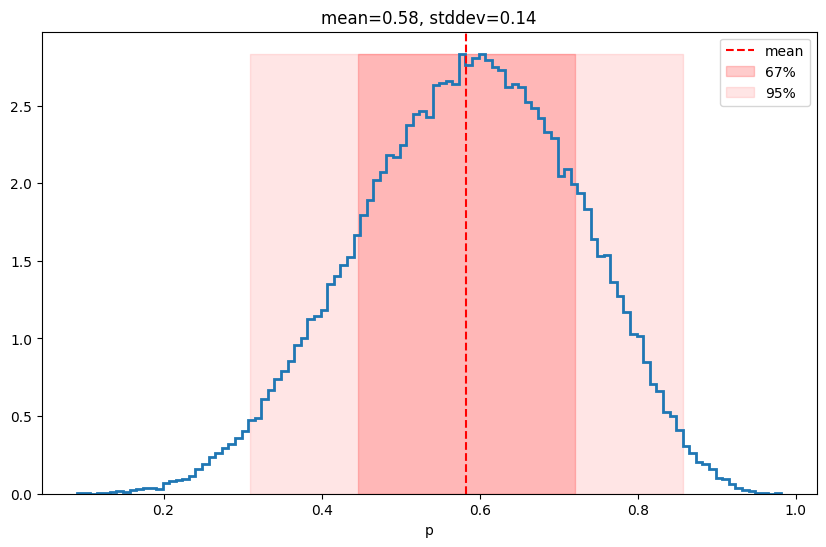

In [5]:
Dp = scipy.stats.beta(7, 5) 
plt.figure(figsize=(10, 6))
height, _, _ = plt.hist(Dp.rvs(100000), histtype="step", lw=2, bins="auto", density=True)
plt.xlabel("p")
plt.title(f"mean={Dp.mean():.2f}, stddev={Dp.std():.2f}")
plt.axvline(Dp.mean(), ls="dashed", color="red", label="mean")
plt.fill_betweenx([0, height.max()], Dp.mean()-Dp.std(), Dp.mean() + Dp.std(),
                  color="red", alpha=0.2, label="67%")
plt.fill_betweenx([0, height.max()], Dp.mean()-2*Dp.std(), Dp.mean() + 2*Dp.std(),
                  color="red", alpha=0.1, label="95%")
plt.legend()

$p$ is likely to be around 0.6, but can be anything from 0.35 to 0.85, with a reasonable probability.

However, this analytical solution is not universal. It is only possible because

1. We have a very simple model of the robot.
1. We assume that we know nothing about $p$ before we run the robot (_uniform prior_).
1. We assume that outcomes are independent and identically distributed.

For anything just a little bit more complicated, we **will not** have an analytical solution and must use a numerical approximation. 

## Generative model

For computing a numerical approximation, we need a model. Our approach is to specify a _generative model_, that is, a model that tells the story of the robot taking an action in the state. We will run _inference_ on the model to get an approximation of the _parameter posterior_, which is, in our case, our belief about the values of $p$.

### $Model$
\begin{aligned}
p & \sim \mathrm{Beta}(1, 1) \\
o & \sim \mathrm{Bernoulli}(p),\,\mbox{for each}\,o \in \pmb{o}
\end{aligned}

The first line specifies the _prior belief_ about $p$. $\mathrm{Beta}(1, 1)$ is a fancy way to say that $p$ is uniformly distributed between 0 and 1:

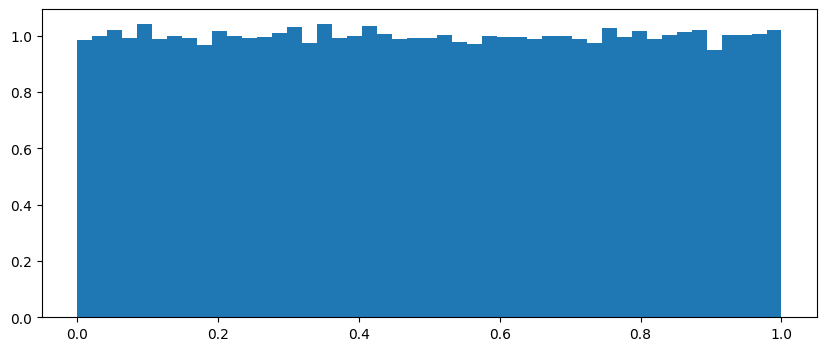

In [6]:
plt.figure(figsize=(10, 4))
plt.hist(scipy.stats.beta(1, 1).rvs(100000), bins="auto", density=True)
_=_

However, we could have chosen a more complex prior, provided we have a reason to. For example, we may believe that $p$ is likely to be around $0.6$ ($\mathrm{Beta}(3, 2)$):

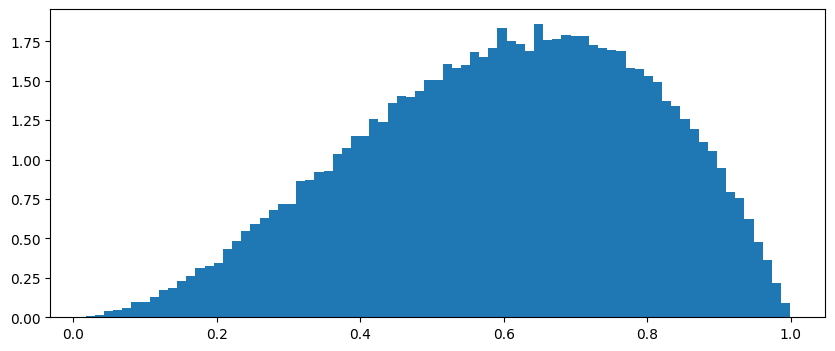

In [7]:
plt.figure(figsize=(10, 4))
plt.hist(scipy.stats.beta(3, 2).rvs(100000), bins="auto", density=True)
_=_

or even that most robots are dumb, but some are very smart:

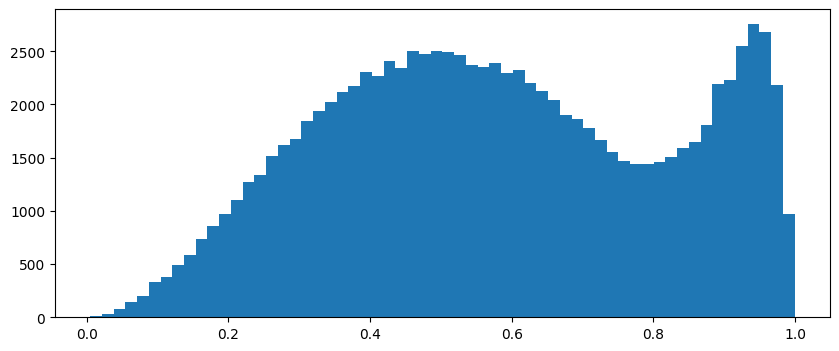

In [8]:
plt.figure(figsize=(10, 4))
plt.hist(numpy.concatenate([
        # a mixture of 0.8 Beta(3, 3) and 0.2 Beta(20, 2)
        scipy.stats.beta(3, 3).rvs(80000), 
        scipy.stats.beta(20, 2).rvs(20000)]), 
    bins="auto")
_=_

The second line above specifies the _conditional distribution_ of observations given $p$, in our case we state that observations are independent, and Bernoulli-distributed. Bernoulli-distributed variables can be either 0 or 1, and the portion of 1s is specified by $p$:

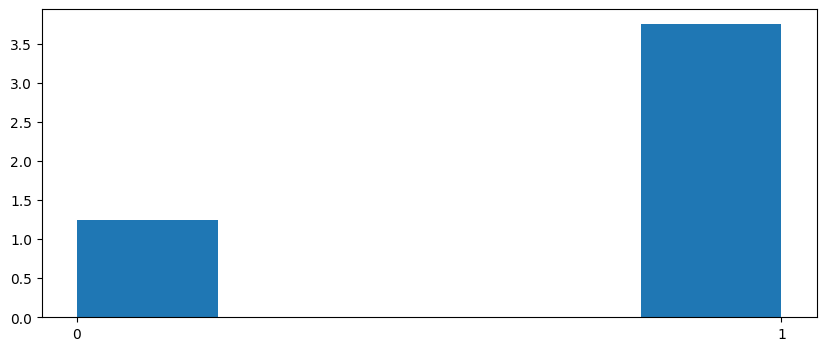

In [9]:
plt.figure(figsize=(10, 4))
plt.hist(scipy.stats.bernoulli(0.75).rvs(100000), bins=5, align='mid', density=True)
plt.xticks([0, 1], [0, 1])
_=_

## Inference from scratch

### T.O.C
1. Analytical Solution
2. MCMC_Metropolis Solution
3. Domain  Solution

1. Given a generative model, we want to approximate the posterior belief about $p$, which we will deote $p|\pmb{o}$.  Commonly, $p|\pmb{o}$ is approximate by a set of samples, say $10\,000$ samples. 
2. Can plot a **histogram**, compute the $⟨p⟩$ and the standard deviation of $p$ .

### Solution 1: Analytical Solution

For inference, we need a function that computes the _joint probability_ of $p$ and $\pmb{o}$. (Believe me we absolutely need it). For computational stability, we will compute everything in _log-space_, that is, instead of probabilities, we will operate on log probabilities.

$\Pr(p)\Pr(o|p) = \Pr(o, p)$

$\log \Pr(p)\Pr(o|p) = \log \Pr(p) + \log \Pr(o|p) = \log \Pr(o, p)$

In [10]:
def logprob_robot(p, obs):
    """Computes log probability of p and os occurring together.
    Returns the log probability.
    """
    logprob = scipy.stats.beta(1, 1).logpdf(p)    # the log probability of p given our prior belief
    for o in obs:
        logprob += scipy.stats.bernoulli(p).logpmf(o)
    return logprob

$$P(p|o) = \frac {P(p)P(o|p)} {P(o)} = \frac {P(p, o)} {P(o)}$$

Different 'guesses" of $p$ will yield different joint log probability

In [11]:
print(f"logprob(0.5, os) = {logprob_robot(0.5, OBSERVATIONS):.2f}, "
      f"logprob(0.6, os) = {logprob_robot(0.6, OBSERVATIONS):.2f}, "
      f"logprob(0.8, os) = {logprob_robot(0.8, OBSERVATIONS):.2f}")


logprob(0.5, os) = -6.93, logprob(0.6, os) = -6.73, logprob(0.8, os) = -7.78


### DIY Markov chain Monte Carlo inference

So, intuitively, we want to call `logprob_robot` with many different values of $p$ and weight all those different values according to the return value of `logprob_robot`. Efficient algorithms for this task are called [Markov chain Monte Carlo](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo). We can implement the simplest version in just a few lines of code, using the [Metropolis algorithm](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm).

In [12]:
def mcmc(logprob, proposal):
    """Implements the Metropolis MCMC algorithm.
    Accepts the logprob function and the proposal distribution, yields the samples.
    """
    p = proposal()
    l = logprob(p)
    while True:
        p_ = proposal()
        l_ = logprob(p_)
        if l_ >= l:
            l = l_
            p = p_
        else:
            threshold = numpy.log(numpy.random.rand())
            if l_ - l > threshold:
                l = l_
                p = p_
        yield p      

First, we generate samples lazily:

In [13]:
samples = mcmc(lambda p: logprob_robot(p, OBSERVATIONS), scipy.stats.beta(1, 1).rvs)

And then collect as many samples as we think we need to approximate the posterior.

In [14]:
p_post = [next(samples) for _ in range(10000)]

Despite having collected only a relatively small number of samples, we manage to approximate the posterior quite well:

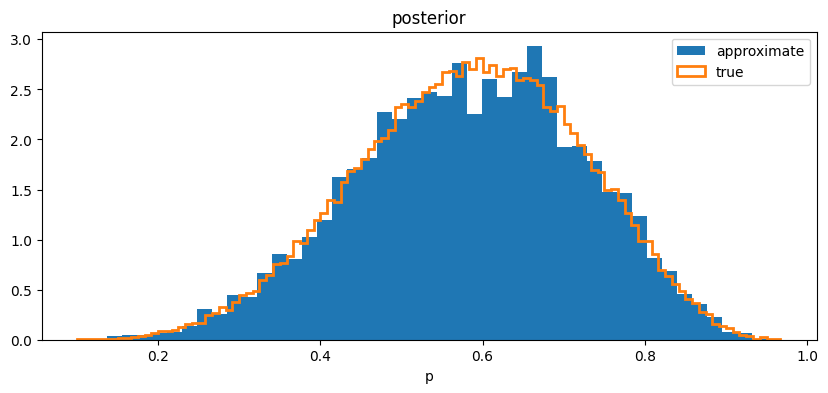

In [15]:
plt.figure(figsize=(10, 4))
plt.title("posterior")
plt.xlabel("p")
plt.hist(p_post, bins="auto", density=True, label="approximate")
plt.hist(Dp.rvs(100000), histtype="step", lw=2, bins="auto", density=True, label="true")
plt.legend()
_=_

In [ ]:
## 

However, this solution is not quite welcoming. 

1. We had to code the joint probability by hand. It was manageable for our simple model, but not trivial for anything even slightly more complicated.
1. We had to code the inference algorithm by hand. Our algorithm looks 'general', but at the cost of being extremely inefficient with anything but single-variable models with bounded support.
1. We guessed the number of samples we need, and, because we know what the right answer would be, we know our guess was good enough. In real models, we obviously do not know the right answer, and need a way to assess _convergence_ of our inference.

## Generative modelling with NumPyro

[NumPyro](https://num.pyro.ai) is a library for generative modelling and inference in Python. It is a handy tool to solve problems like ours, and works well with hundreds of latent variables (like our $p$) and elaborated generative models. 

We will now reimplement our solution in NumPyro. 

In [16]:
import numpyro
import numpyro.distributions as dist
import jax
import time

### Generative model

First thing NumPyro provides is a [DSL](https://en.wikipedia.org/wiki/Domain-specific_language) for specifying generative models. Instead of writing the joint probability function, we can just re-write the statistical definition of the model, only in Python.

```python
def robot(observations):
    # p ~ Beta(1, 1)
    p = numpyro.sample("p", dist.Beta(1, 1))
    with numpyro.plate("obs", len(obs)):
        # o ~ Bernoulli(p)
        numpyro.sample("o", dist.Bernoulli(p), obs=observations)
```

The model above is a complete NumPyro model, suitable for inference. Behind the scenes, it computes the joint log probability, but it looks just like the statistical generative model.

We could use the model as implemented, but to be able to do a bit more _automatically_, we want to be able to call the model without observations — to simulate model's predictions before any data is seen (this is called _predictive prior_).

In [17]:
def robot(obs=None, nobs=len(OBSERVATIONS)):
    """Robot model with NumPyro.
    """
    if obs is not None:  # we want to pass None to obs if 
        nobs = len(obs)
    # p ~ Beta(1, 1)
    p = numpyro.sample("p", dist.Beta(1, 1))
    with numpyro.plate("obs", len(obs) if obs is not None else nobs):
        # o ~ Bernoulli(p)
        numpyro.sample("o", dist.Bernoulli(p), obs=obs)

### Prior predictive

The first step we want to perform with any model is to examine its prior predictive, that is, the kind of observations this model is in general able to 'imagine'. NumPyro provides class `Predictive` for this purpose.

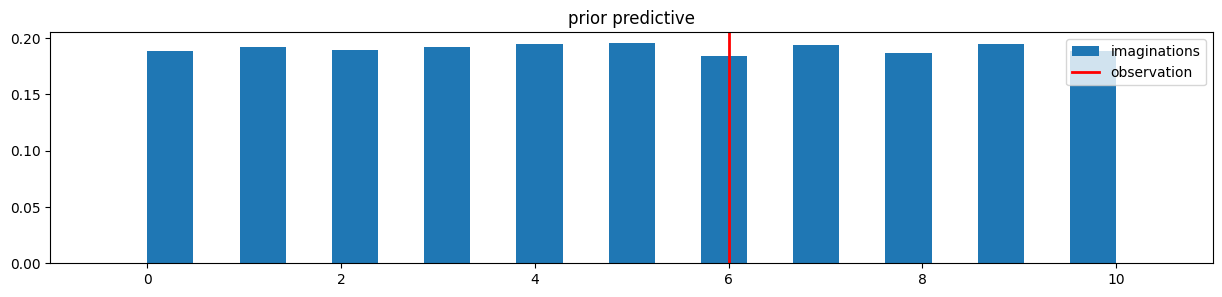

In [18]:
prior_predictive = numpyro.infer.Predictive(robot, num_samples=10000)
prior_samples = prior_predictive(jax.random.PRNGKey(int(time.time() * 1E6)))

plt.figure(figsize=(15, 3))
plt.xlim(-1, len(OBSERVATIONS)+1)
plt.hist([sum(o) for o in prior_samples['o']], density=True, bins=len(OBSERVATIONS)*2+1, label="imaginations")
plt.axvline(sum(OBSERVATIONS), color="red", lw=2, label="observation")
plt.title("prior predictive")
plt.legend()
_=_

The above plot of prior predictive helps us analyse our model even before we performed any inference. The actual observation (number of successes out number of trials) is _well covered by the prior_. This means that, given this observation, the model will be able to infer the posterior reasonably efficiently. If, for example, the prior mass on the actual observation were very small, such as if the prior were $\mathrm{Beta(1, 10)}$, our model would be _misspecified_, and the inference would not work well.

### Inference

NumPyro supplies efficient MCMC inference algorithms. A default choice is called [NUTS](https://arxiv.org/abs/1111.4246).  NumPyro's NUTS is both much faster and much better converging inference algorithm than the naive version of MCMC we wrote earlier.

In [19]:
nuts_kernel = numpyro.infer.NUTS(robot)
mcmc = numpyro.infer.MCMC(
    nuts_kernel,
    num_warmup=500,
    num_chains=4,
    num_samples=5000)

mcmc.run(jax.random.PRNGKey(int(time.time() * 1E6)), obs=jax.numpy.array(OBSERVATIONS))

<ipython-input-19-dbcb2c3cc82c>:2: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(
sample: 100%|██████████| 5500/5500 [00:02<00:00, 2553.95it/s, 3 steps of size 1.13e+00. acc. prob=0.92]


When the algorithm finished running, the first thing we want to check is whether the inference results are informative. For this purpose, we 

1. Run several (4) Monte Carlo chains.
2. Print and review summary statistics of the samples in the chains.

In [20]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         p      0.58      0.14      0.59      0.36      0.81   7651.42      1.00

Number of divergences: 0


The two important numbers here are the number of effective samples `n_eff` ($N_{eff}$) and the metric called `r_hat` ($\hat R$). 
1. $N_{eff}$ estimates how many 'independent'  samples we got in the posterior. The way MCMC works, we may get 10000 samples which are all have the same or very close values, and do not approximate the posterior well. 
2. [$\hat R$](https://mc-stan.org/rstan/reference/Rhat.html) compares correlation with the same chain and among different chains. MCMC is a random algorithm, and different Markov chains may behave differently. We want the model to be good enough, and to run it for long enough, so that different chains 'forget' about their starting points and converge to the same random behavior. if $\hat R$ is close to 1, then we are fine. If $\hat R$ is greater than 1.1, we should discard the posterior and look for ways to improve the converged, either through a longer warmup, or by modifying the model.

Our model is small and simple, so the inference has come out well, but you are welcome to ‘break’ the model or the inference to get pathological values of $N_{eff}$ or $\hat R$, just for fun and education.

### Posterior

The first thing we want to show is, just in our DIY solution, the posterior distribution of $p$. The inferred posterior approximates quite well the true posterior, which is quite expected.

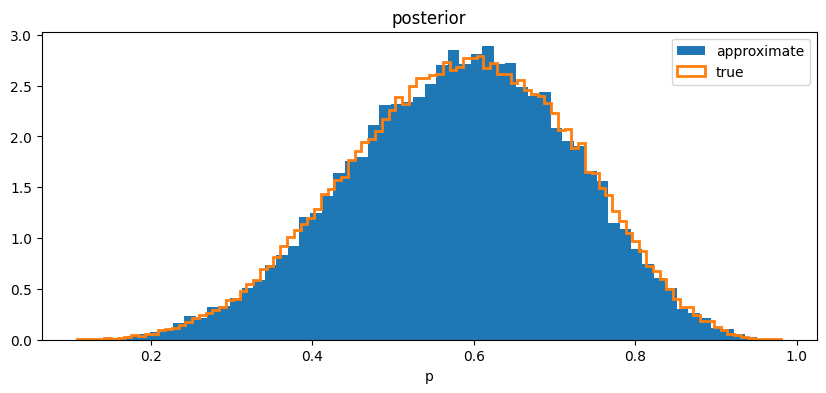

In [21]:
plt.figure(figsize=(10, 4))
plt.title("posterior")
plt.xlabel("p")
plt.hist(mcmc.get_samples()['p'], density=True, bins="auto", label="approximate")
plt.hist(Dp.rvs(100000), histtype="step", lw=2, bins="auto", density=True, label="true")
plt.legend()
_=__=_

###  Posterior predictive

In reality though, we won't be able to check the approximate posterior by comparing to the true one (we do not know the true one). So, we should fine another way to check that the model converged to something reasonable. We can do this using _posterior predictive_.

We generate the posterior predictive using the same tool as we used for prior predictive, only instead of sampling $p$ from the prior we use the posterior samples of $p$. Technically, this is achieved by passing `posterior_samples` to `Predictive`.

In [22]:
posterior_predictive = numpyro.infer.Predictive(robot, posterior_samples=mcmc.get_samples())
posterior_samples = posterior_predictive(jax.random.PRNGKey(int(time.time() * 1E6)))

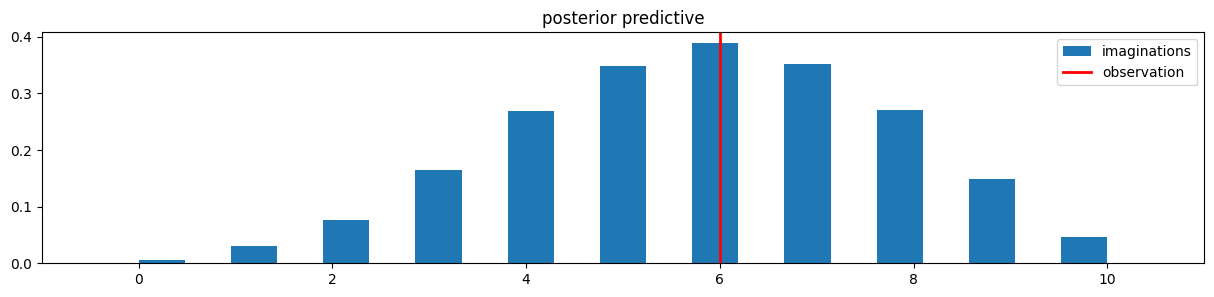

In [23]:
plt.figure(figsize=(15, 3))
plt.xlim(-1, len(OBSERVATIONS)+1)
plt.hist([sum(o) for o in posterior_samples['o']], density=True, bins=len(OBSERVATIONS)*2+1, label="imaginations")
plt.axvline(sum(OBSERVATIONS), color="red", lw=2, label="observation")
plt.title("posterior predictive")
plt.legend()
_=_

The above plot looks fine: the imaginations are concentrated around the observation, with  the maximum mass near the observation. We can formalize this by computing the ‘p-value’ of the observation given the predictive posterior, that is, the probability that an imagined observation is greater (or smaller) than the actual one:

In [24]:
p_value = sum(posterior_samples['o'].sum(axis=1) >= sum(OBSERVATIONS))/len(posterior_samples['o'])
print(f"p_value = {p_value:.3f}")

p_value = 0.573


Depending on how strong the prior is and how much data we have, p_value between 0.3 and 0.7 is an indication that our posterior is fine. Extreme values, like 0.1 or 0.9 or more extreme, point at a problem in the model.

---------------------------------------
This completes the first part of the tutorial. In the second part we will deal with model evaluation, extension, and comparison of the basic and extended model.